In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import time 
import pandas as pd
from torch import nn
import collections

import progressbar
from progressbar import FormatLabel, Percentage, Bar, ETA


from data_loader import DataLoader
#import viewer functions
from dataViewer import plotTraj, animatePreview, animateLoc, animateTraj

import hdf5_utils as hd
from simulation import Agent, Engine
import h5py
import os


%matplotlib notebook
%load_ext autoreload
%autoreload 2

plt.style.use("plotstyle.mplstyle")

np.random.seed(42)

In [2]:
def batch(arr1, arr2, n):
    """Yield successive n-sized chunks from l."""
    size = len(arr1)
    for i in range(0, size, n):
        yield arr1[i:min(i + n, size)], arr2[i:min(i + n, size)]
        
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth
        

In [255]:


#hidden_layer = [32, 32, 64, 128, 128, 40]

#hidden_layer = [ 128, 128, 40, 32, 32, 64,]
#hidden_layer = [ 50, 30, 10, 20, 30, 30,]
#hidden_layer = [28 ,20, 10, 10]

scan = {"ug-180-015":0,
        "ug-180-030":1,
        "ug-180-060":2,
        "ug-180-085":3,
        "ug-180-095":4,
        "ug-180-110":5,
        "ug-180-140":6,
        "ug-180-230":7,
       }


load_traindata = True

dset = {'neighbors':6,
        'ret_vel':True,
        'nn_vel': True,
        'truth_with_vel': True,
        'shuffle':True,
        'mode': "wrap",
        'step_nr':1,
        'downsample':8,
        'fps':16,
        'name':  "ug-180-015" #"ug-180-230"#"ug-100-045", #"ao-360-400_combine"
       }

# availiabel 180: 15, 30, 60, 85, 95 110, 140, 230


param = {'input_s': 2+2*dset['ret_vel']  + dset['neighbors']*(2+2*dset['nn_vel']), #(number_nei+1)*4,
         'hidden_s': [32, 32, 64, 128, 128, 40],
         'output_s': 2+dset['truth_with_vel']*2,
         'epochs':30,
         'batch_size':10,
         'lr':1e-3,
         'decay':0.1,
         'decay_step':5,
         #'dtype':torch.float,
         'device':torch.device("cuda:0"),
         'dataset':dset,
        }

#FPS = 16

BG = "Datasets/UG/ug.png"

#PATH_1 = "Datasets/UG/UG-roh_nachkorrigiert/ug-100-007.txt"



PATH = "Datasets/AO/"
PATH = "Datasets/UG/UG-roh_nachkorrigiert/"
PATH2 = "data/HD5/"


In [256]:

ds = DataLoader(PATH + dset['name'] + ".txt")

ds.load()

print("Persons: ", ds.data.p.max())
print("Frame maximum :", ds.data.f.max() )


sufix = "_nn{}_s{}_vr{}_m{}_vi{}_st{}_d{}".format(dset['neighbors'],
                                 dset['shuffle'],
                                 dset['truth_with_vel'],
                                 dset['mode'],
                                 dset['ret_vel']+dset['nn_vel'], 
                                 dset['step_nr'],
                                 dset['downsample'])


f_name = PATH2+param['dataset']['name']+sufix+'.h5'

if os.path.isfile(f_name) and load_traindata:

    train, val, test, param['dataset'] = hd.load_trainingdata(f_name)
    scan_idx = scan[param['dataset']['name']]
    print("Trainingdata has been loaded")
    
else:
    f_x = ds.flip_x

    augmentation = []# [f_x]
    train, val, test = ds.get_train_data(dset['neighbors'], 
                                         step_nr=dset['step_nr'],
                                         downsample=dset['downsample'],
                                         augmentation=augmentation,
                                         ret_vel=dset['ret_vel'],
                                         nn_vel=dset['nn_vel'],
                                         shuffle=dset['shuffle'],
                                         truth_with_vel=dset['truth_with_vel'],
                                         mode=dset['mode'])
    dset['date'] = time.ctime()
    dset['creator'] = 'zehndiii'
    dset['augmentation'] = str(augmentation)
    param['dataset'] = dset
    
    hd.save_trainingdata(f_name, param, train, val, test)
    scan_idx = scan[param['dataset']['name']]
    print("Training data saved to : {}".format(PATH2+f_name+sufix+'.h5'))

loaded 54 persons
Persons:  54
Frame maximum : 1643
Trainingdata has been loaded


/home/zehndi/CNN/Projects/ai-team/hdf5_utils.py:131: H5pyDeprecationWarning:

dataset.value has been deprecated. Use dataset[()] instead.

/home/zehndi/CNN/Projects/ai-team/hdf5_utils.py:132: H5pyDeprecationWarning:

dataset.value has been deprecated. Use dataset[()] instead.

/home/zehndi/CNN/Projects/ai-team/hdf5_utils.py:133: H5pyDeprecationWarning:

dataset.value has been deprecated. Use dataset[()] instead.



In [5]:
hd.print_stats(PATH2+param['dataset']['name']+sufix+'.h5')

File: data/HD5/ug-180-015_nn6_sTrue_vrTrue_mwrap_vi2_st1_d8.h5/
|     Size: 1.06MB
|     @augmentation: []
|     @creator: zehndiii
|     @date: Wed Nov 25 18:35:01 2020
|     @downsample: 8
|     @fps: 16
|     @mode: wrap
|     @name: ug-180-015
|     @neighbors: 6
|     @nn_vel: True
|     @ret_vel: True
|     @shuffle: True
|     @step_nr: 1
|     @truth_with_vel: True
|
|Group: test 
|     |-----Dataset: input           - Shape: (1745, 28) float32
|     |-----Dataset: truth           - Shape: (1745, 4) float32
|
|Group: train 
|     |-----Dataset: input           - Shape: (5235, 28) float32
|     |-----Dataset: truth           - Shape: (5235, 4) float32
|
|Group: val 
|     |-----Dataset: input           - Shape: (1746, 28) float32
|     |-----Dataset: truth           - Shape: (1746, 4) float32


In [39]:
t_i_a.append(train[0])
t_t_a.append(train[1])
v_i_a.append(val[0])
v_t_a.append(val[1])
te_i_a.append(test[0])
te_t_a.append(test[1])

In [17]:
t_i_a = []
t_t_a = []
v_i_a = []
v_t_a = []
te_i_a = []
te_t_a = []




In [40]:
print(len(t_i_a))

t_i_a_n = np.vstack(t_i_a)
t_t_a_n = np.vstack(t_t_a)

v_i_a_n = np.vstack(v_i_a)
v_t_a_n = np.vstack(v_t_a)

te_i_a_n = np.vstack(te_i_a)
te_t_a_n = np.vstack(te_t_a)

#120826,

8


In [42]:
train = (t_i_a_n, t_t_a_n)
val = (v_i_a_n, v_t_a_n)
test = (te_i_a_n, te_t_a_n)


dset['date'] = time.ctime()
dset['creator'] = 'zehndiii'
dset['augmentation'] = str([])
dset['name'] = 'all'
param['dataset'] = dset

sufix = "_nn{}_s{}_vr{}_m{}_vi{}_st{}_d{}".format(dset['neighbors'],
                                 dset['shuffle'],
                                 dset['truth_with_vel'],
                                 dset['mode'],
                                 dset['ret_vel']+dset['nn_vel'], 
                                 dset['step_nr'],
                                 dset['downsample'])


f_name = PATH2+param['dataset']['name']+sufix+'.h5'

hd.save_trainingdata(f_name, param, train, val, test)


# Format training data as tensors

In [44]:


t_input, t_truth = train
v_input, v_truth = val
test_input, test_truth = test


if param['dataset']['name']=='all':
    p = np.random.permutation(len(t_truth))
    #np.random.shuffle(steps_input)
    print("extra shuffeling")
    t_input = t_input[p]
    t_truth = t_truth[p]
    

t_i = torch.from_numpy(t_input).to(param['device'])
t_t = torch.from_numpy(t_truth).to(param['device'])

v_i = torch.from_numpy(v_input).to(param['device'])
v_t = torch.from_numpy(v_truth).to(param['device'])

test_i = torch.from_numpy(test_input).to(param['device'])
test_t = torch.from_numpy(test_truth).to(param['device'])




extra shuffeling


'all'

# Define Model

In [6]:


# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNet, self).__init__()
        self.fc_in = nn.Linear(input_size, hidden_size[0]) 
        
        #self.fc_hidden = []
        #for i in range(len(hidden_size)-1):
        self.fc_hidden_1 = nn.Linear(hidden_size[0], hidden_size[1])
        self.fc_hidden_2 = nn.Linear(hidden_size[1], hidden_size[2])
        self.fc_hidden_3 = nn.Linear(hidden_size[2], hidden_size[3])
        
        self.fc_hidden_4 = nn.Linear(hidden_size[3], hidden_size[4])
        self.fc_hidden_5 = nn.Linear(hidden_size[4], hidden_size[5])

        
        self.fc_out = nn.Linear(hidden_size[-1], output_size)
        self.relu = nn.ReLU()
        #self.drop = nn.Dropout(0.1)
    
    def forward(self, x):
     
        out = self.relu(self.fc_in(x))
        
        #for i in range(len(self.fc_hidden)):
        #    out = self.relu(self.fc_hidden[i](out))
        
        out = self.relu(self.fc_hidden_1(out))
        out = self.relu(self.fc_hidden_2(out))
        out = self.relu(self.fc_hidden_3(out))
        out = self.relu(self.fc_hidden_4(out))
        #out = self.drop(out)
        out = self.relu(self.fc_hidden_5(out))
        
        
        out = self.fc_out(out)
        return out


model = NeuralNet(param['input_s'], param['hidden_s'], param['output_s']).to(param['device'])


In [46]:
#choose loss function - can be played around with
loss_fn = torch.nn.MSELoss(reduction='mean')


optimizer = torch.optim.Adam(model.parameters(), lr=param['lr'])

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=param['decay_step'], gamma=param['decay'])


In [47]:

d_len = t_i.shape[0]


pbar = progressbar.ProgressBar(max_value=param['epochs'])
widgets = [FormatLabel(''), ' ', Percentage(), ' ', Bar(), ' ', ETA()]
pbar = progressbar.ProgressBar(widgets=widgets, maxval=param['epochs']*d_len)
pbar.start()

training_loss = []
validation_loss = [0.0]

for t in range(param['epochs']):
    
    # Train on Batches
    
    p = np.random.permutation(len(t_i))
    t_i = t_i[p]
    t_t = t_t[p]
    
    for  y, (t_i_b, t_t_b) in  enumerate(batch(t_i, t_t, param['batch_size'])):
        y_pred = model(t_i_b)
       
        loss = loss_fn(y_pred, t_t_b)

        model.zero_grad()
       
        loss.backward()

        optimizer.step()
        
        widgets[0] = FormatLabel('loss(t/v) : {:.4} / {:.4} | lr={:.4}'.format(loss.item(),
                                                                            validation_loss[-1],
                                                                            optimizer.param_groups[0]['lr']))
        pbar.update(t*d_len+y*param['batch_size'])
        
        if y%10==9:
            training_loss += [loss.cpu().detach().numpy()]
    
    # Test on validation
    
    loss = []
    with torch.no_grad():
        for v_i_b, v_t_b in batch(v_i, v_t, param['batch_size']):
            y_pred = model(v_i_b)
            loss += [loss_fn(y_pred, v_t_b).cpu().detach().numpy()]
            pbar.update()
    validation_loss.append( np.array(loss).mean() )
    
    scheduler.step()
        

pbar.finish()




loss(t/v) : 35.35 / 93.84 | lr=1e-06  63% |############        | ETA:   0:43:58IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

loss(t/v) : 159.0 / 93.84 | lr=1e-07  82% |################    | ETA:   0:21:12IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

loss(t/v) : 81.57 / 93.84 | lr=1e-08 100% |####################| Time:  2:01:47


<IPython.core.display.Javascript object>


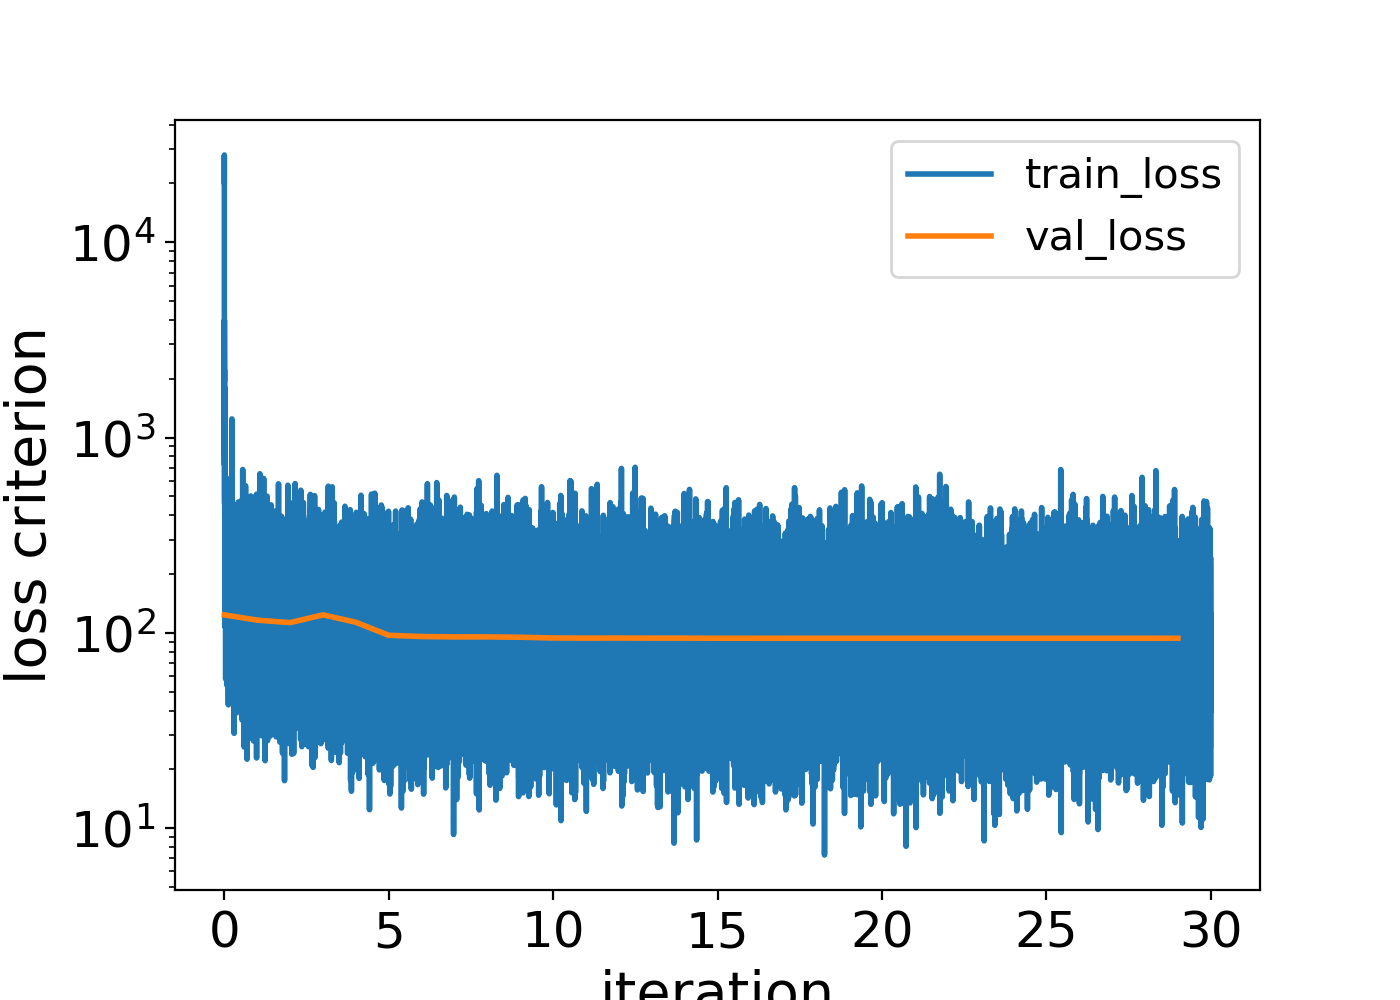

30
147900


In [48]:

train_loss = np.array(training_loss)
val_loss = np.array(validation_loss[1:])

plt.figure()
plt.semilogy(np.arange(len(train_loss))*10*param['batch_size']/d_len, train_loss, label="train_loss")
plt.semilogy(np.arange(len(val_loss)), val_loss, label="val_loss" )
plt.xlabel("iteration")
plt.ylabel("loss criterion")
plt.legend()
plt.show()
print(len(val_loss))
print(len(train_loss))

In [49]:
model.eval()



NeuralNet(
  (fc_in): Linear(in_features=28, out_features=32, bias=True)
  (fc_hidden_1): Linear(in_features=32, out_features=32, bias=True)
  (fc_hidden_2): Linear(in_features=32, out_features=64, bias=True)
  (fc_hidden_3): Linear(in_features=64, out_features=128, bias=True)
  (fc_hidden_4): Linear(in_features=128, out_features=128, bias=True)
  (fc_hidden_5): Linear(in_features=128, out_features=40, bias=True)
  (fc_out): Linear(in_features=40, out_features=4, bias=True)
  (relu): ReLU()
)

# Check on test set

100% (164337 of 164337) |################| Elapsed Time: 0:01:48 Time:  0:01:48


<IPython.core.display.Javascript object>


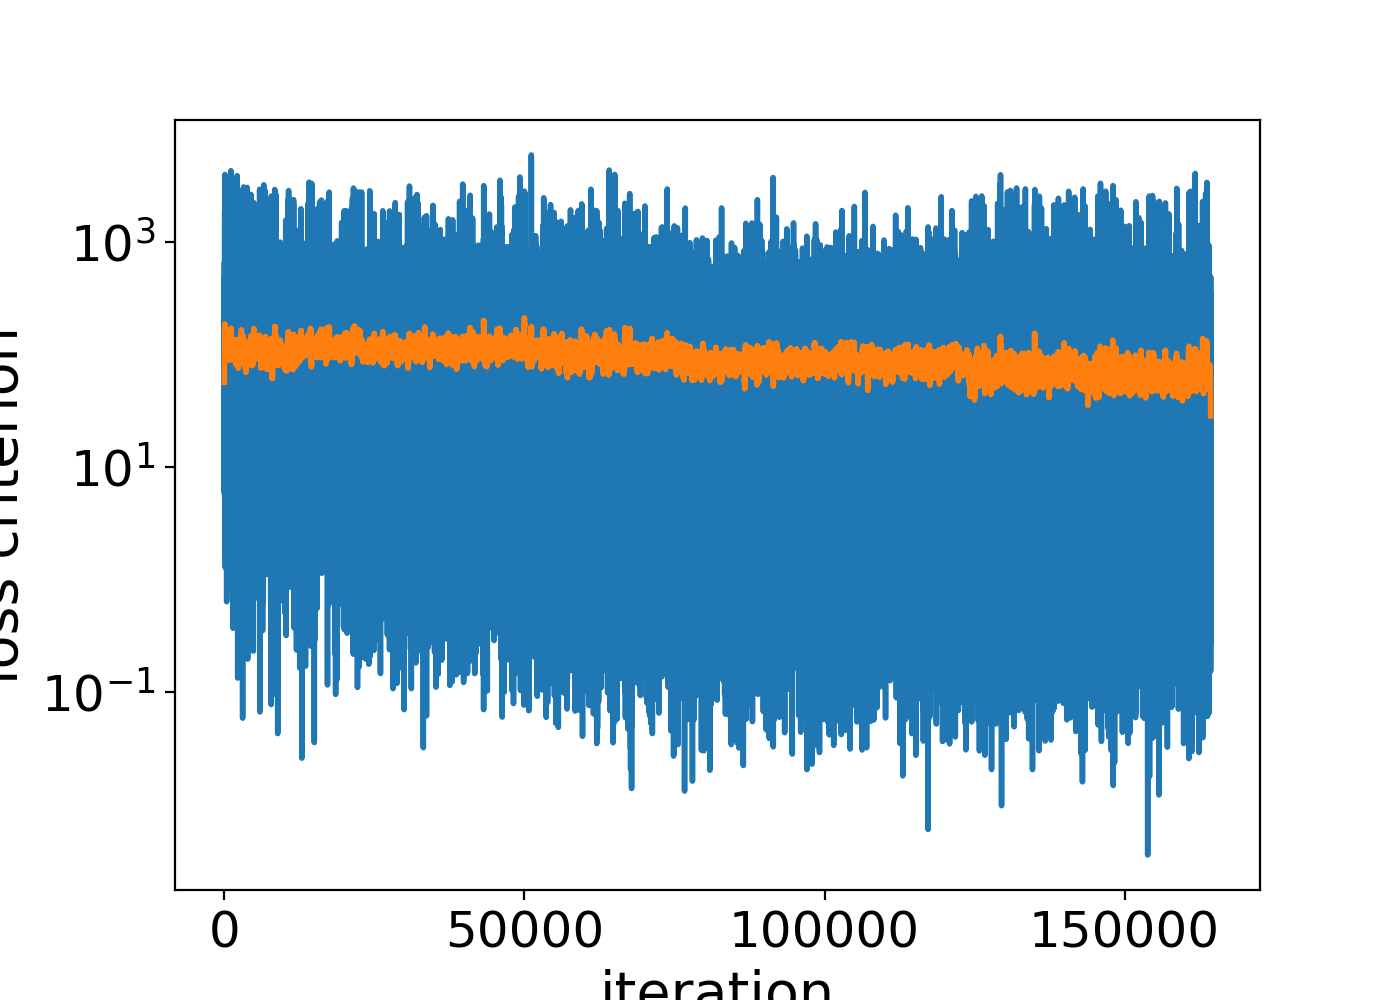

In [50]:

test_dat = []

pbar = progressbar.ProgressBar(maxval=len(test_i))
pbar.start()

i = 0

with torch.no_grad():
    for (ti, tt) in zip(test_i, test_t):
        pred = model(ti)
        loss = loss_fn(pred, tt)
        test_dat.append(loss.cpu().detach().numpy())
     
        if i%10:
            pbar.update(i)
        
        i += 1
        
    pbar.finish()
    
test_dat = np.array(test_dat)

plt.figure()
plt.semilogy(np.arange(len(test_dat)), test_dat)
plt.semilogy(np.arange(len(test_dat)), smooth(test_dat, 100))
plt.xlabel("iteration")
plt.ylabel("loss criterion")
plt.show()

# Save/ Load model

In [7]:
PATH_M = "data/model/"
name = "model_UG_downsample_good_"
#name = "model_UG_downsample_good_"
name = "model_phaseplott_v2_"
name = "model_phaseplott_with_all_v2_"

suffix_m = "_nn{}_vel{}{}_{}_s{}_{}_{}_e{}_lr{}".format(param['dataset']['neighbors'],
                                                         param['dataset']['ret_vel'],param['dataset']['nn_vel'],param['dataset']['truth_with_vel'],
                                                         param['input_s'],param['hidden_s'],param['output_s'],
                                                         param['epochs'],
                                                         param['lr'],
                                                        )


#f_name = PATH_M+name+"sweep_vel.h5"
f_name = PATH_M+name+suffix_m+".h5"    

#hd.print_stats(f_name)
suffix_m

'_nn6_velTrueTrue_True_s28_[32, 32, 64, 128, 128, 40]_4_e30_lr0.001'

In [52]:

param['msg'] = "No augementation "


hd.save_torch(model, optimizer, f_name, param, prefix="model_1", scan=True)

In [8]:
model , param = hd.load_torch(f_name, NeuralNet, prefix="model_1")
model.eval()

multi_model
{'hidden_s': array([ 32,  32,  64, 128, 128,  40]), 'input_s': 28, 'layers': array(['fc_in.weight', 'fc_in.bias', 'fc_hidden_1.weight',
       'fc_hidden_1.bias', 'fc_hidden_2.weight', 'fc_hidden_2.bias',
       'fc_hidden_3.weight', 'fc_hidden_3.bias', 'fc_hidden_4.weight',
       'fc_hidden_4.bias', 'fc_hidden_5.weight', 'fc_hidden_5.bias',
       'fc_out.weight', 'fc_out.bias'], dtype=object), 'output_s': 4}


/home/zehndi/CNN/Projects/ai-team/hdf5_utils.py:180: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  stat[l] = torch.from_numpy(mod.get(l).value,).to(layer_param['device'])


NeuralNet(
  (fc_in): Linear(in_features=28, out_features=32, bias=True)
  (fc_hidden_1): Linear(in_features=32, out_features=32, bias=True)
  (fc_hidden_2): Linear(in_features=32, out_features=64, bias=True)
  (fc_hidden_3): Linear(in_features=64, out_features=128, bias=True)
  (fc_hidden_4): Linear(in_features=128, out_features=128, bias=True)
  (fc_hidden_5): Linear(in_features=128, out_features=40, bias=True)
  (fc_out): Linear(in_features=40, out_features=4, bias=True)
  (relu): ReLU()
)

In [9]:
hd.print_stats(f_name)

File: data/model/model_phaseplott_with_all_v2__nn6_velTrueTrue_True_s28_[32, 32, 64, 128, 128, 40]_4_e30_lr0.001.h5/
|     Size: 185.09KB
|     @mode: multi_model
|     @models: [b'dummy' b'model_1']
|
|Group: model_1 
|     @batch_size: 10
|     @creator: zehndiii
|     @date: Sat Nov 28 22:14:29 2020
|     @decay: 0.1
|     @decay_step: 5
|     @device: cuda:0
|     @epochs: 30
|     @lr: 0.001
|     @mode: single_model
|     @msg: No augementation 
|     |
|     |Group: dataset 
|     |     @augmentation: []
|     |     @creator: zehndiii
|     |     @date: Sat Nov 28 20:03:01 2020
|     |     @downsample: 8
|     |     @fps: 16
|     |     @mode: wrap
|     |     @name: all
|     |     @neighbors: 6
|     |     @nn_vel: True
|     |     @ret_vel: True
|     |     @shuffle: True
|     |     @step_nr: 1
|     |     @truth_with_vel: True
|     |
|     |Group: model 
|     |     @hidden_s: [ 32  32  64 128 128  40]
|     |     @input_s: 28
|     |     @layers: ['fc_in.weight' 'fc_in.bi

In [ ]:
[] + ["hallo"]

# Singel agent

In [10]:



test_person = 10

da = DataLoader(None)


da.copy(ds)
# crop the standing phase
da.data = da.data[ da.data['f']>100]

frames_o, pos_vel_o = da.person(test_person, )
#frames, pos_vel = da.grab_roi(frames_o, pos_vel_o, x_pad=50)

da.remove_person(test_person)

print(frames_o[0], frames_o[-1])

agent = Agent(model,
              FPS=param['dataset']['fps']/param['dataset']['downsample'],
              pos_vel_0=pos_vel_o[0],
              frame_0=int(frames_o[0]/param['dataset']['downsample'])*param['dataset']['downsample'],
              truth_with_vel=param['dataset']['truth_with_vel'],
              device=param['device'],
              id=1000+test_person )



print(agent.id )
print(pos_vel_o[0])


sim = Engine(da, agents=[agent],
             stop_agent=True,
             nn=param['dataset']['neighbors'],
             ret_vel=param['dataset']['ret_vel'],
             nn_vel=param['dataset']['nn_vel'],
             truth_with_vel=param['dataset']['truth_with_vel'],
             mode=param['dataset']['mode'],
             downsample=param['dataset']['downsample'],
            )

sim.run(0, 1000)#frames_o[-1], )


dp = DataLoader(None)
dp.copy(sim.ds)



dp.append_person(test_person, frames_o, pos_vel_o[:,:2], vel=pos_vel_o[:,2:] )


262 406
1010
[-484.22    -45.6165   56.128    95.7936]
sim from : 0 to 1000


frame: 1000 100% |#############################################| Time:  0:00:01


<IPython.core.display.Javascript object>


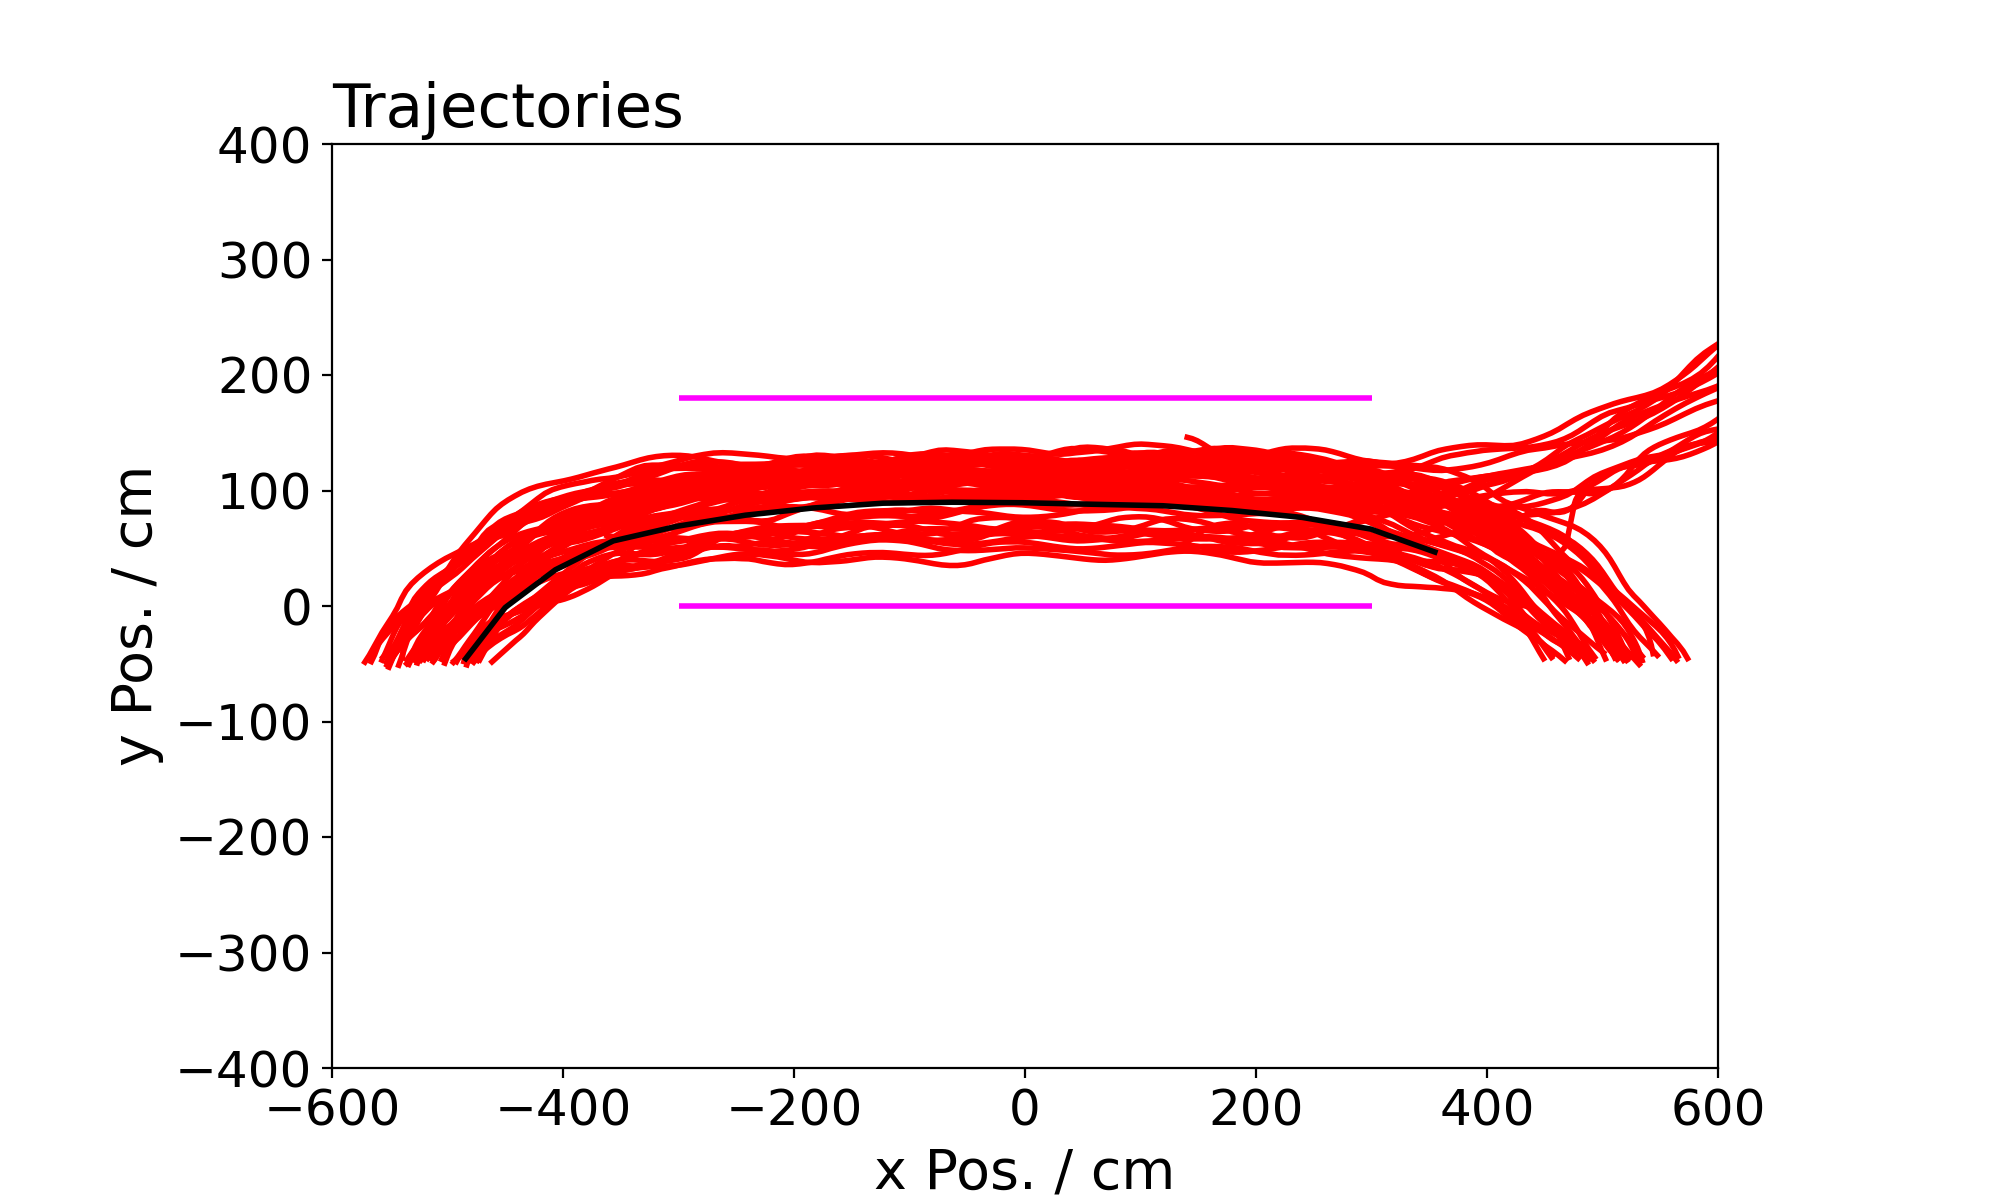

In [11]:

dp.interpolate_person(1000+test_person)

plotTraj(dp,  boundaries=[-600, 600, -400, 400],
         people=None,
         ai=[ 1000+test_person],#test_person,
         legend=False, cor=True,
         title="Trajectories",
         path="trajectories.png",
         save=False)

<IPython.core.display.Javascript object>


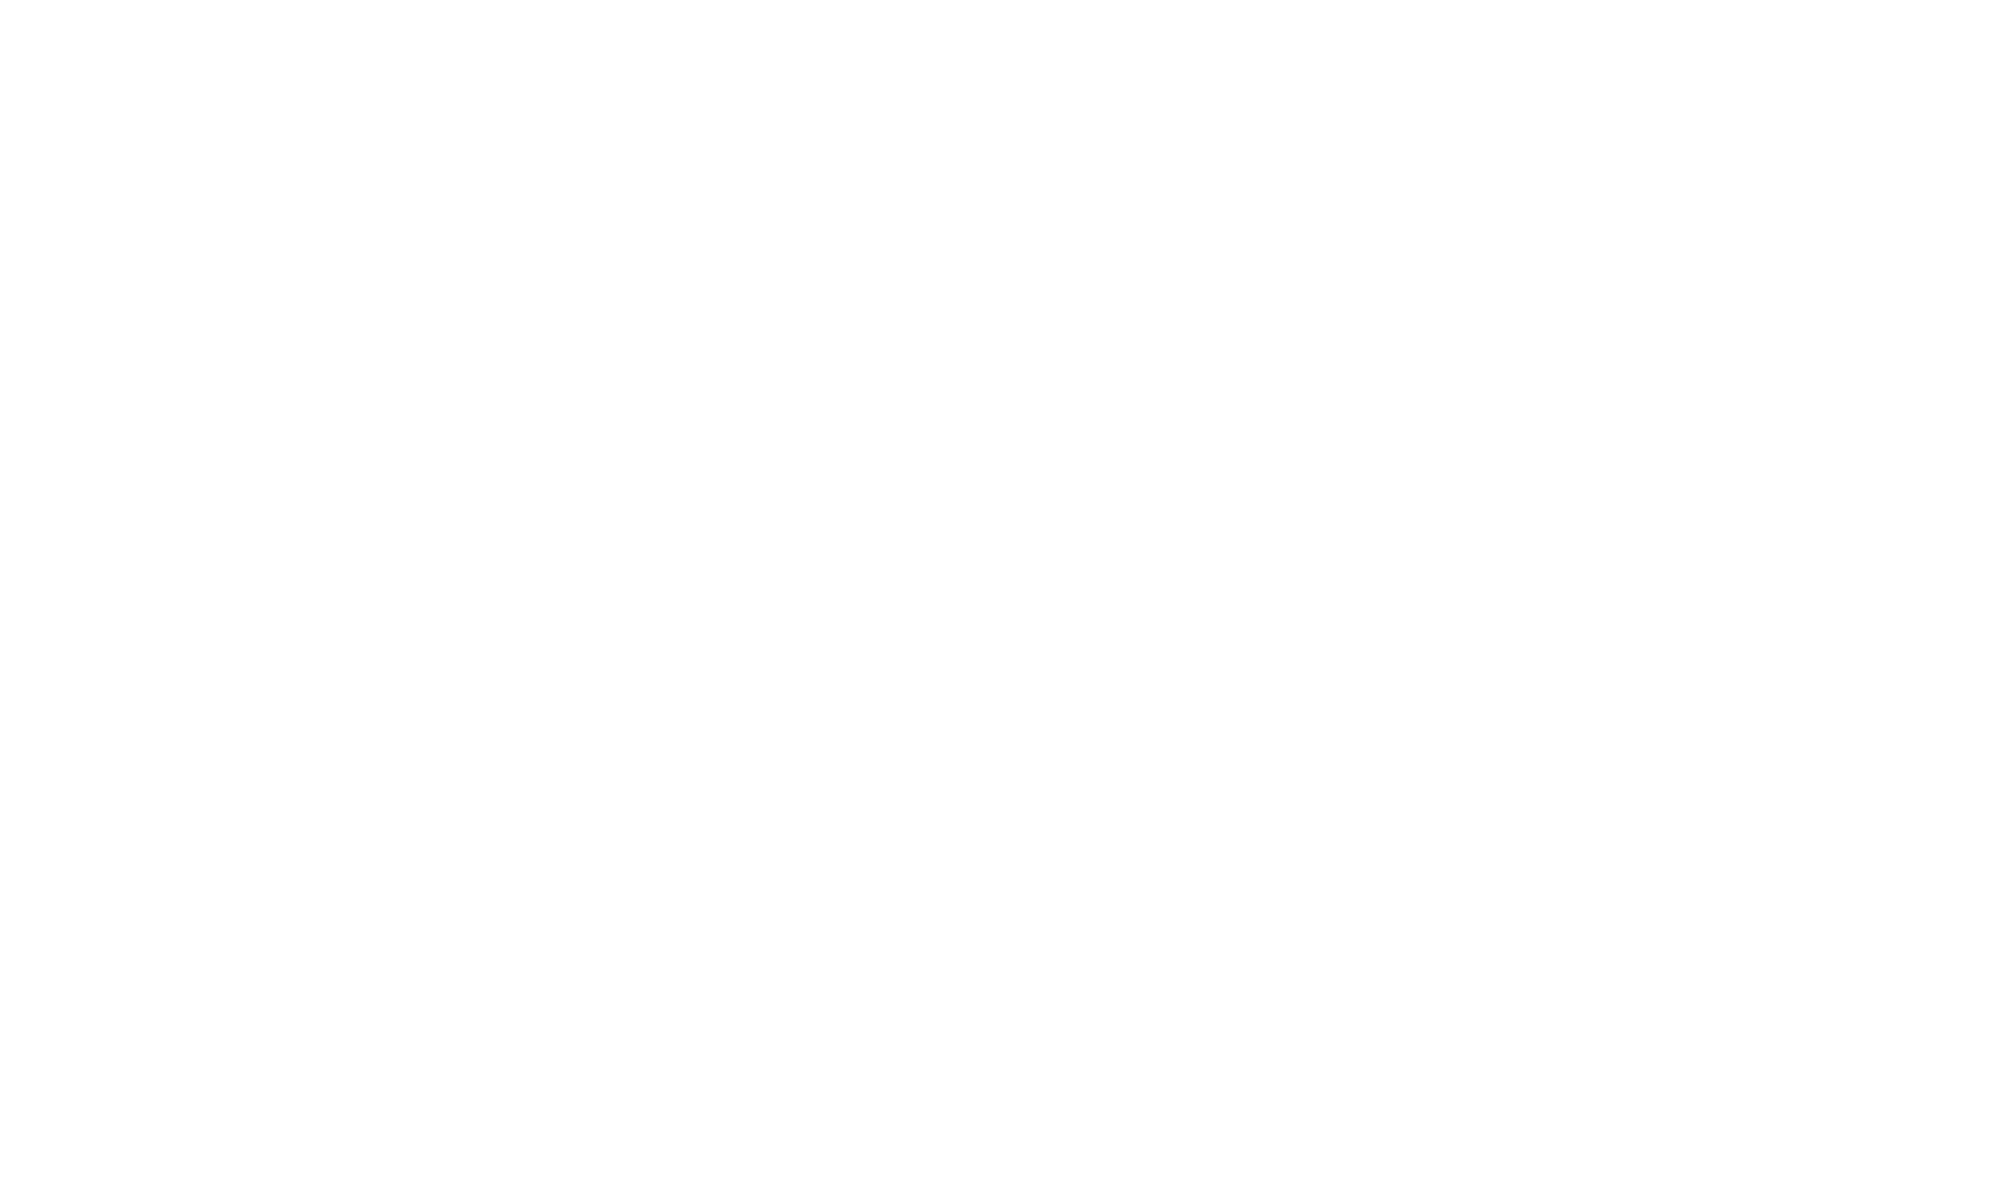

In [12]:
ani = animateLoc(dp, frame_start=frames_o[0], frame_stop=frames_o[-1],ai=[1000+test_person],
#ani = animateLoc(dp, frame_start=1000, frame_stop=1200,ai=[1000+test_person],
             boundaries=[-800, 600, -200, 400], step=2, fps=16, title="ululululu", save=True,
             path="downsapling_8.gif", cor=True,
             )
display(ani)

In [ ]:
animatePreview(dp, boundaries=[-600, 600, -250, 150], step=5)

In [ ]:
ani = animateTraj(dp, frame_start=frames_o[0], frame_stop=frames_o[-1], boundaries=[-600, 600, -250, 150], step=1, fps=16, title="Trajectory Animation")
ani

In [ ]:
type(param['input_s'])

# Multi agent simulation

People in Dataset:  0
Agents in Dataset:  51
Frame max:  1643
sim from : 0 to 1643


frame: 1643 100% |#############################################| Time:  0:00:04


dataset ready!


<IPython.core.display.Javascript object>


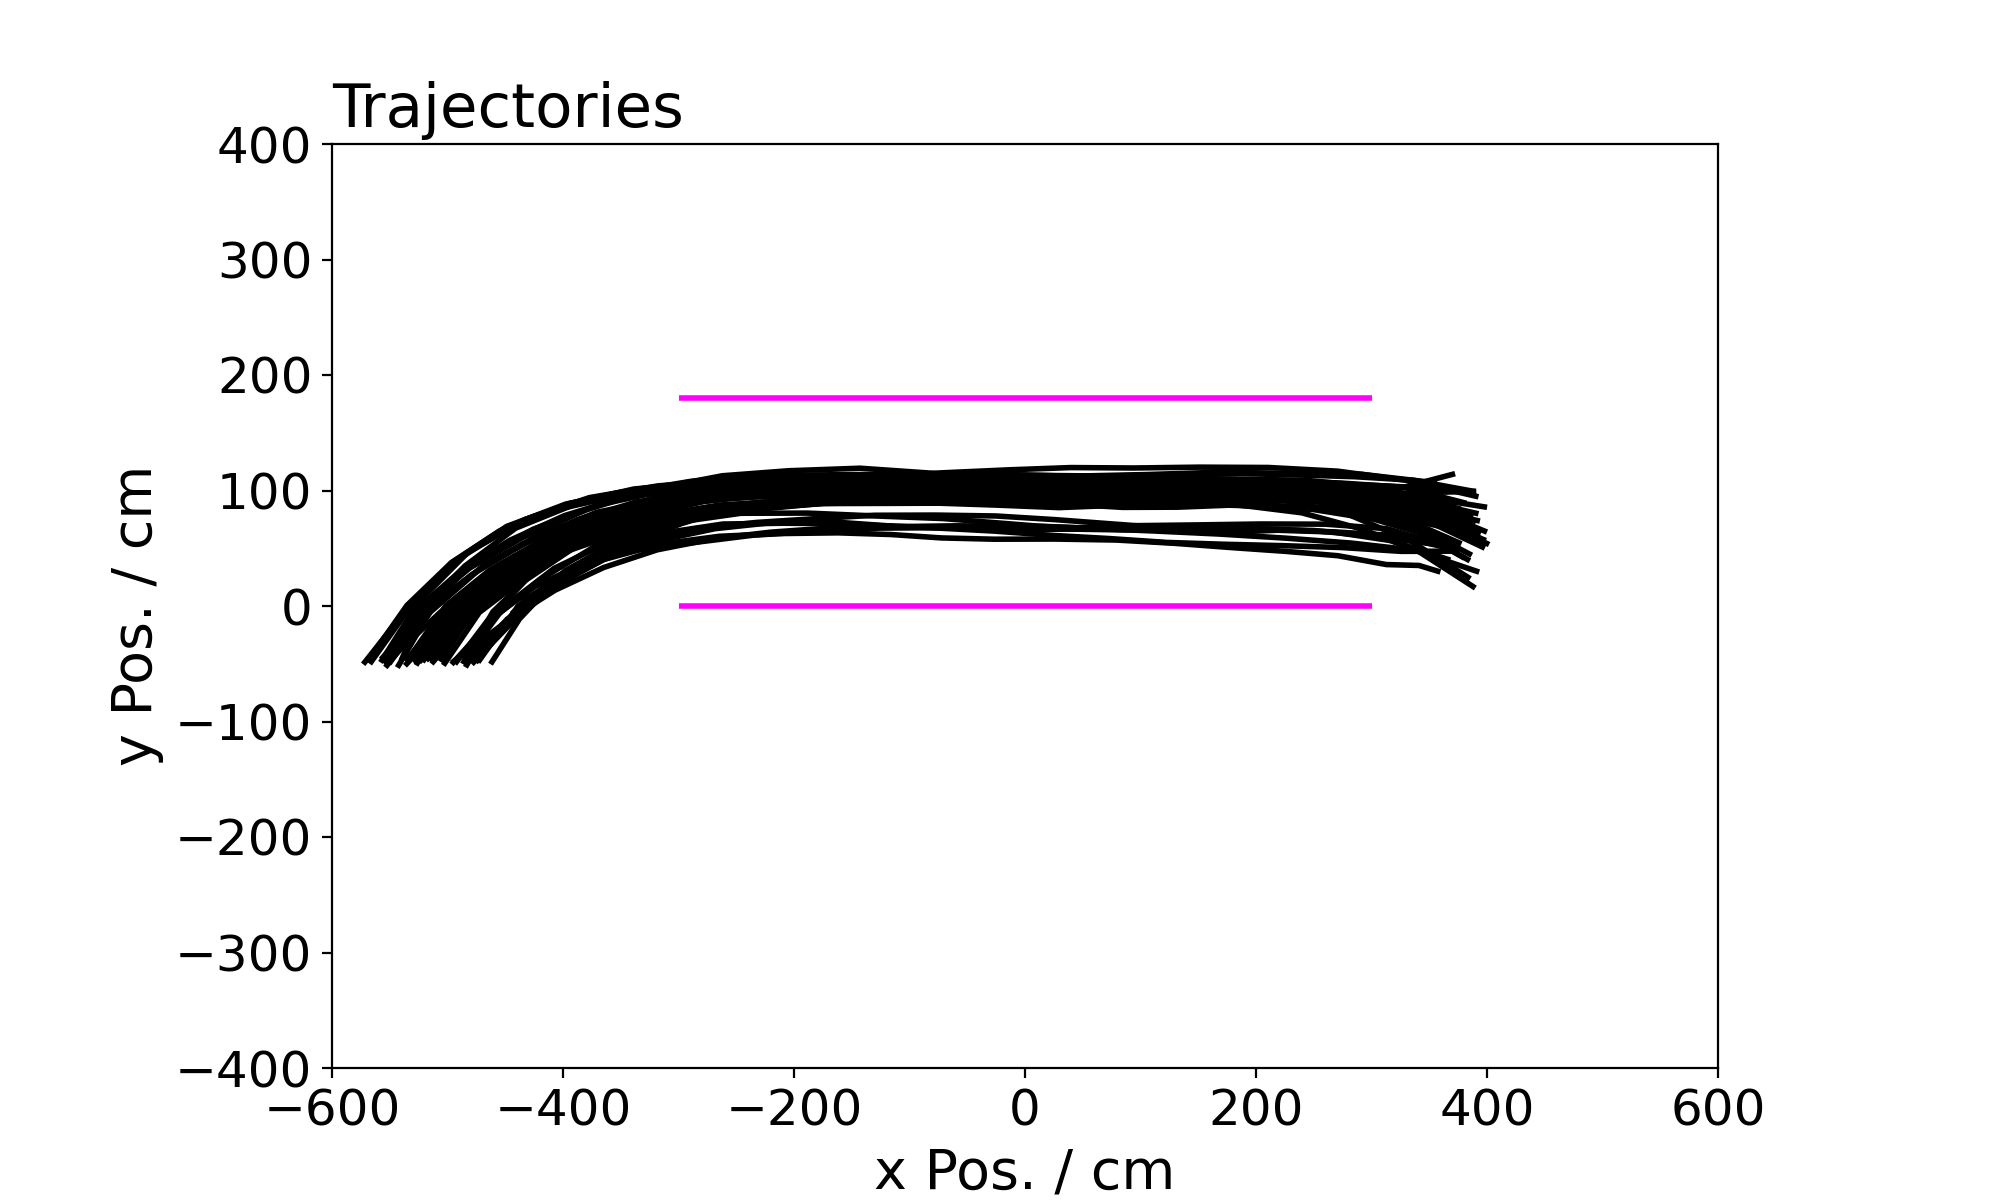

In [257]:
agents_id = np.array([10, 13, 16,  20, 22, 26,  30, 35, 40, ]) #120, 160, 200])

#agents_id, _ = ds.frame(5)



da = DataLoader(None)

da.copy(ds)
da.data = da.data[ da.data['f']>250]


agents_id = da.data['p'].unique()#[]

agents = []
agent_speed = np.zeros_like(agents_id)

frame_max = 0

for j, test_person in enumerate(agents_id):

    frames_o, pos_vel_o =  da.person( test_person, )
    #frames_o, pos_vel_o =  da.grab_roi( *da.person(test_person, ), x_pad=100 )
    
    #agent_speed[j] = get_mean_speed(da, test_person)
    da.remove_person(test_person)

    
    if len(frames_o)<1:
        continue
    
    frame_max = max(frames_o[-1], frame_max)
    
    agents += [Agent(model,
                     FPS=param['dataset']['fps']/param['dataset']['downsample'],
                     pos_vel_0=pos_vel_o[0],
                     frame_0=int(frames_o[0]/param['dataset']['downsample'])*param['dataset']['downsample'],
                     truth_with_vel=param['dataset']['truth_with_vel'],
                     device=param['device'],
                     id=1000+test_person )]

#for id in da.data['p'].unique():
#    da.remove_person(id)

print("People in Dataset: ", da.persons)
print("Agents in Dataset: ", len(agents))
print("Frame max: ", frame_max)

sim = Engine(da, agents=agents,
             nn=param['dataset']['neighbors'],
             ret_vel=param['dataset']['ret_vel'],
             nn_vel=param['dataset']['nn_vel'],
             truth_with_vel=param['dataset']['truth_with_vel'],
             mode=param['dataset']['mode'],
             downsample=param['dataset']['downsample'],
             stop_agent=True)

sim.run(0,frame_max, )


# Dataset for plotting
dp = DataLoader(None)
dp.copy(sim.ds)

# Dataset for analysing

do = DataLoader(None)

da.copy(ds)
do.copy(sim.ds)

for p in da.data['p'].unique():
    frames_b, pos_vel_b =  da.person( p, )
    do.append_person(p, frames_b, pos_vel_b[:,:2], vel=pos_vel_b[:,2:] )

do.save("data/Output/train_onall_v2/all_agents_all_set{}".format(param['dataset']['name']))  
print("dataset ready!")

plotTraj(dp,  boundaries=[-600, 600, -400, 400],
         people=None,cor=True,
         ai=agents_id+1000,
         legend=False,
         title="Trajectories",
         path="trajectories.png",
         save=False)



In [258]:
#for j in agents_id:
#    get_mean_speed(dp, 1000+j)

dp.data = dp.data.sort_values('f')
animatePreview(dp, boundaries=[-600, 600, -250, 200], step=1)

In [199]:
def get_mean_speed(data, id, roi=((-200, 180),(200, 0)), mode="both", normalize=False, pos=(0, 0)):
    frames, pos_vel = data.person(id)
    frames, pos_vel = data.grab_roi(frames, pos_vel, box=roi, x_pad=0 )
    
    if len(frames)==0:
        return np.nan
    
    if not normalize:
        if mode =='x':
             vel_m = pos_vel[:,2].mean()
        elif mode == 'y':
             vel_m = pos_vel[:,3].mean()
        elif mode == 'both':
             vel_m = np.sqrt((pos_vel[:,2:]**2).sum(axis=1)).mean()
    else:
        if mode =='x':
            vel = pos_vel[:,2]
            
            r = pos_vel[0] - pos[0]
            vel /= r
            
            vel_m = vel.mean()
        elif mode == 'y':
            vel = pos_vel[:,3]
            
            r = pos_vel[1] - pos[1]
            vel /= r
            
            vel_m = vel.mean()
        elif mode == 'both':
            vel = np.sqrt((pos_vel[:,2:]**2).sum(axis=1))
            
            r = np.sqrt(( (pos_vel[:,:2]-pos)**2).sum(axis=1))
            vel /= r
            
            vel_m = vel.mean()

    #print("ID ", id ," vel :",  vel_m)
    return vel_m


def get_density(data, frame, roi=((-200, 180),(200, 0)) ):
    
    id_s, pos_vel = data.frame(frame)
    
    id, _ = data.grab_roi( id_s, pos_vel, box=roi, x_pad=0, y_pad=0, ret_mask=False )
    
    area = (roi[1][0]-roi[0][0]) * (roi[0][1]-roi[0][0])
    
    density = len(id)/ area
    
    return density




In [262]:


dataset = DataLoader(None)
dataset.copy(do)

roi=((-200, 180),(200, 0))

#15,    30,  60,  85,   95, 110,  140,  230 
#1070, 360, 480, 600,  800, 1000,  600, 250
#.                    500   500 ,  300. 250
m_len = 50
start_f = 500
stop_f = start_f + m_len



dataset.data = dataset.data[ dataset.data['f']>=start_f]
dataset.data = dataset.data[ dataset.data['f']<stop_f]

dataset_p = DataLoader(None)
dataset_a = DataLoader(None)
dataset_p.copy(dataset)
dataset_a.copy(dataset)

dataset_p.data = dataset_p.data[ dataset_p.data['p']<1000]
dataset_a.data = dataset_a.data[ dataset_a.data['p']>=1000]





frames_p = dataset_p.data['f'].unique() 
frames_a = dataset_a.data['f'].unique() 

pers_id = dataset_p.data['p'].unique()
agent_id = dataset_a.data['p'].unique()

#print(pers_id, agent_id)

for y in agent_id:
    dataset_a.interpolate_person(y)

density_p = np.zeros_like(frames_p, dtype=np.float )
density_a = np.zeros_like(frames_a, dtype=np.float )

velocity_p = np.zeros_like(pers_id, dtype=np.float)
velocity_a = np.zeros_like(agent_id, dtype=np.float)



for i, f in enumerate(frames_p):
    density_p[i] = get_density(dataset_p, f, roi )
    
for i, f in enumerate(frames_a):
    density_a[i] = get_density(dataset_a, f, roi )

for j, p in enumerate(pers_id):
    velocity_p[j] = get_mean_speed(dataset_p, p, roi=roi, mode="both", normalize=False)

for j, p in enumerate(agent_id):
    velocity_a[j] = get_mean_speed(dataset_a, p, roi=roi, mode="both", normalize=False)

to_m = 100
to_m2 = 100*100


density_pers = density_p.mean() * to_m2
density_pers_err = density_p.std(ddof=1) * to_m2

density_agent = density_a.mean() * to_m2
density_agent_err = density_a.std(ddof=1) * to_m2






velocity_pers = np.nanmean( velocity_p) / to_m
velocity_pers_err = np.nanstd( velocity_p, ddof=1) / to_m

velocity_agent = np.nanmean(velocity_a) / to_m
velocity_agent_err = np.nanstd(velocity_a, ddof=1) / to_m

print("Density Person: ", density_pers, "+/-", density_pers_err)
print("Density Agent: ",density_agent, "+/-", density_agent_err)

print("Velocity Person: ",velocity_pers, "+/-", velocity_pers_err)
print("Velocity Agent: ",velocity_agent, "+/-", velocity_agent_err)



Density Person:  0.14210526315789476 +/- 0.03077200290177613
Density Agent:  0.15350877192982457 +/- 0.053716880324192515
Velocity Person:  1.1457940094965064 +/- 0.08793642143123317
Velocity Agent:  1.0984130661768832 +/- 0.03512958128271612


<IPython.core.display.Javascript object>


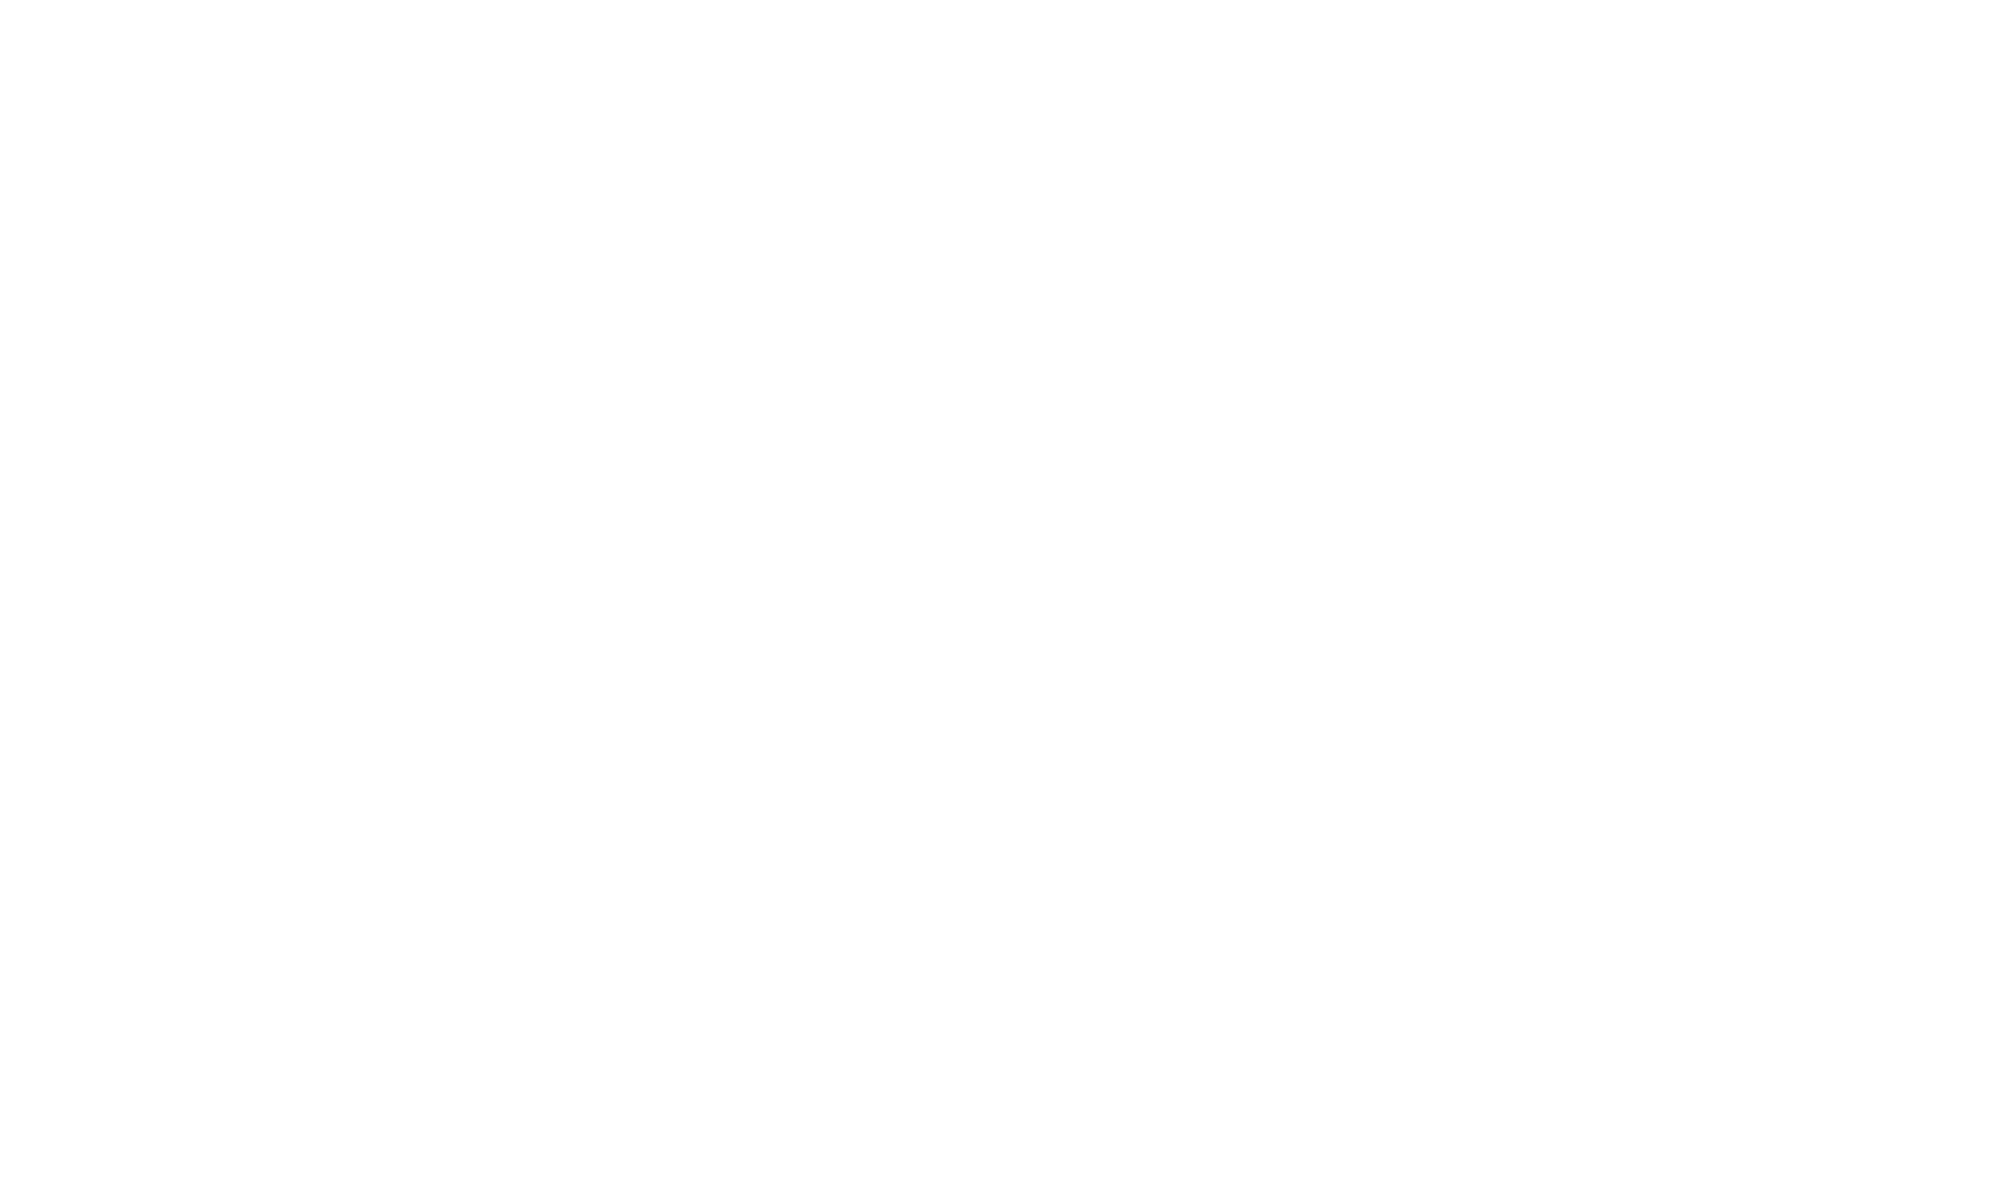

In [263]:

for y in agent_id:
    dataset_a.interpolate_person(y)

ani = animateLoc(dataset_a, frame_start=start_f, frame_stop=stop_f,ai=agents_id+1000,
             boundaries=[-600, 500, -200, 300], step=1, fps=16,
             title=r"Corridor - {} - $\varrho$={:.3}".format( param['hidden_s'], density_agent), save=True,
             path="data/Output/train_onall_v2/all_agents_all_set{}.gif".format(param['dataset']['name']), cor=True)

display(ani)

<IPython.core.display.Javascript object>


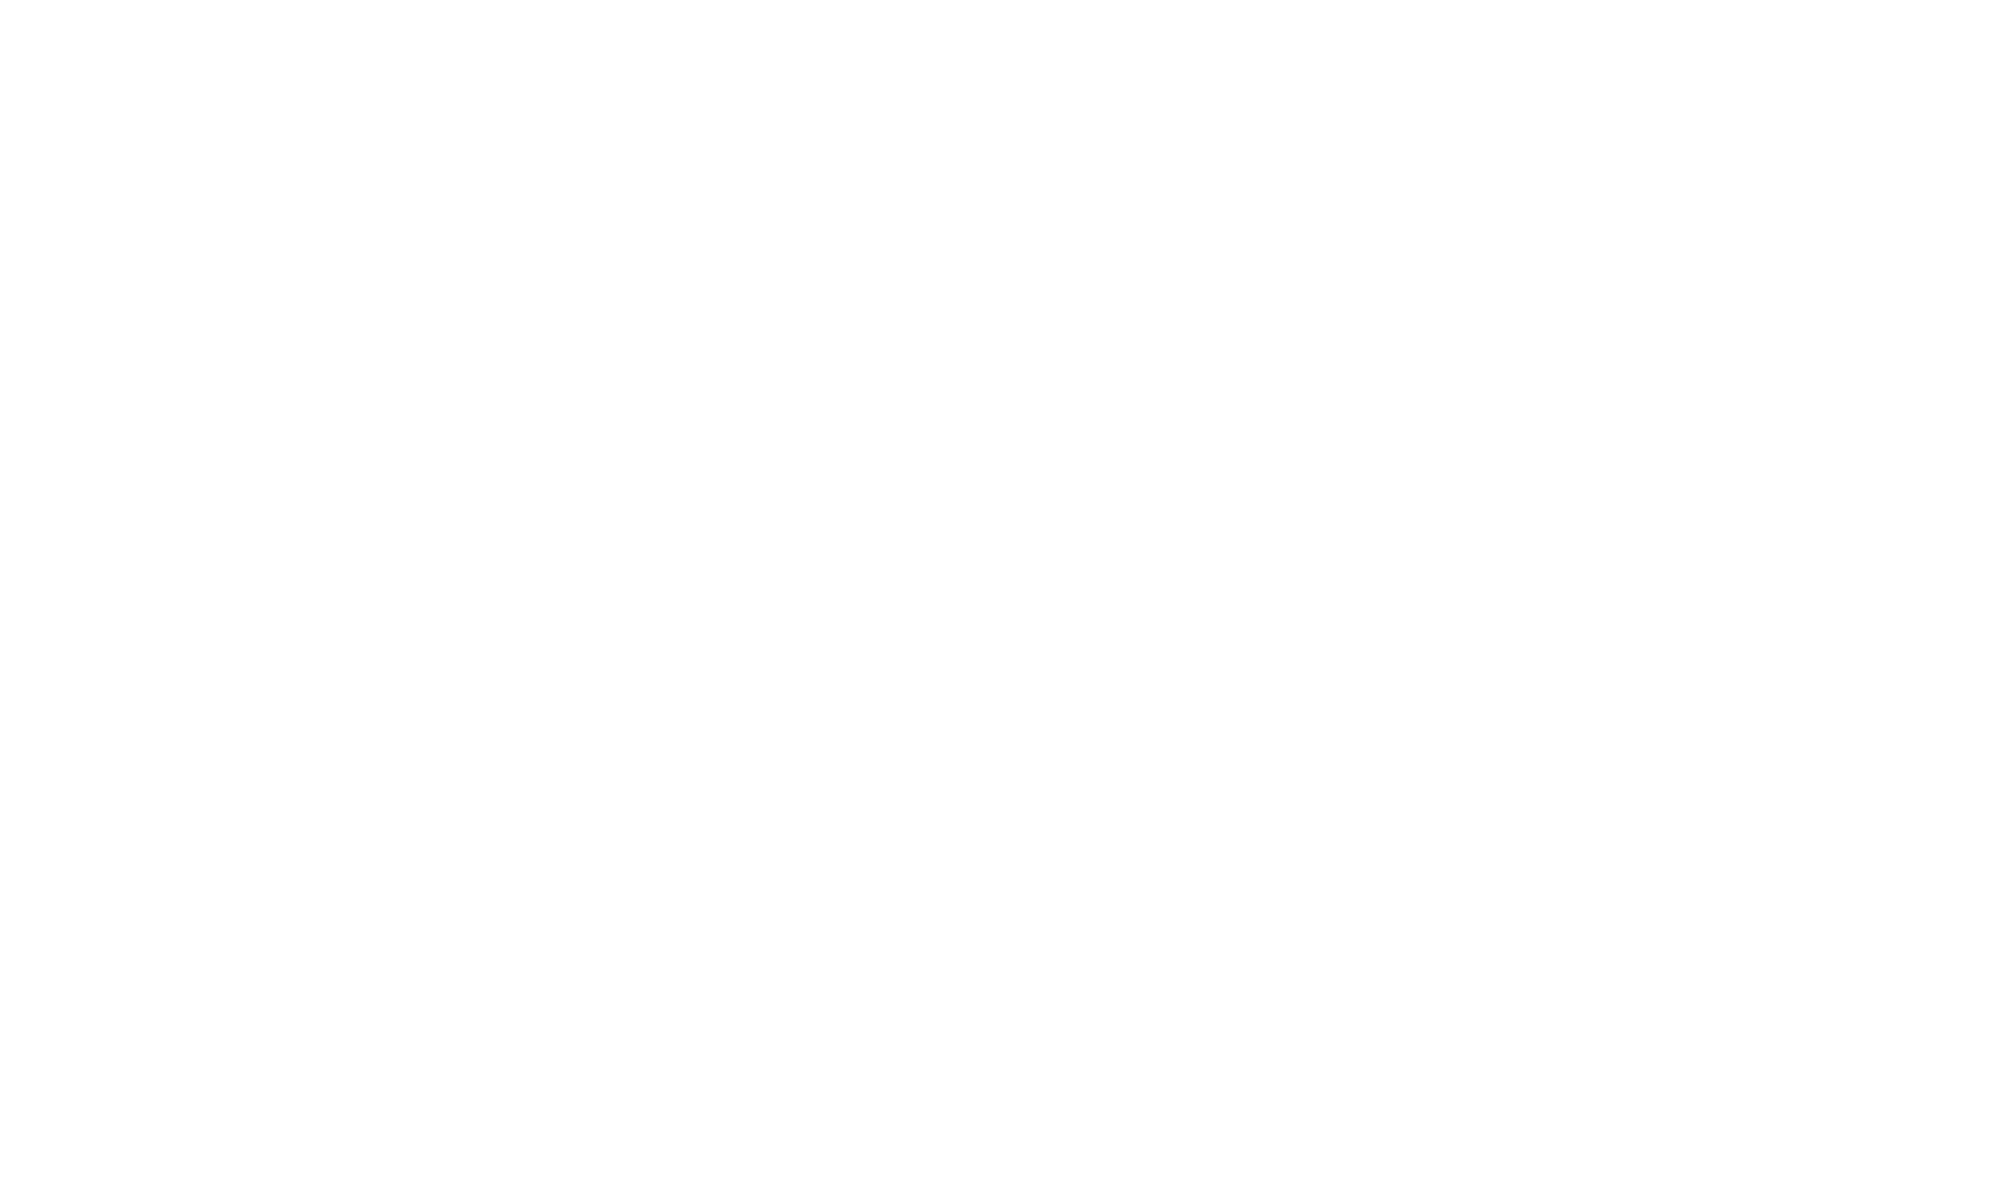

In [264]:



ani = animateLoc(dataset_p, frame_start=start_f, frame_stop=stop_f,ai=None,
             boundaries=[-600, 500, -200, 300], step=1, fps=16,
             title=r"Corridor - {} - $\varrho$={:.3}".format(param['hidden_s'], density_pers), save=True,
             path="data/Output/train_onall_v2/truth_all_set_{}.gif".format(param['dataset']['name']), cor=True)

display(ani)


In [265]:
output = "data/Output/train_onall_v2/scan_all_agents_trainon_all.npy"

if os.path.isfile(output):
    scan = np.load(output)
    

else:
    scan = np.zeros((len(scan), 8))
    
scan[scan_idx] = [density_pers, density_pers_err, density_agent, density_agent_err,
                  velocity_pers, velocity_pers_err, velocity_agent, velocity_agent_err]
np.save(output, scan)

In [266]:
np.load(output)

array([[0.14210526, 0.030772  , 0.15350877, 0.05371688, 1.14579401,
        0.08793642, 1.09841307, 0.03512958],
       [0.27631579, 0.04408285, 0.26315789, 0.05884389, 1.01300039,
        0.05646433, 1.05590458, 0.04255235],
       [0.49736842, 0.03298859, 0.39473684, 0.05884389, 0.76787302,
        0.0425684 , 0.88646   , 0.01129636],
       [0.65131579, 0.05981166, 0.625     , 0.03603438, 0.57018294,
        0.05873599, 0.65363444, 0.05194499],
       [0.52763158, 0.07576144, 0.52631579, 0.11008685, 1.21008822,
        0.0985108 , 1.10122337, 0.05374414],
       [0.95131579, 0.05825552, 0.66885965, 0.04952452, 0.49229727,
        0.0547926 , 0.57331887, 0.02712668],
       [0.31710526, 0.07242333, 0.30701754, 0.06794708, 1.3387985 ,
        0.09825639, 1.32110257, 0.03560167],
       [1.93552632, 0.0595749 , 1.91885965, 0.02685844, 0.19045534,
        0.05556461, 0.18192924, 0.02657929]])

<IPython.core.display.Javascript object>


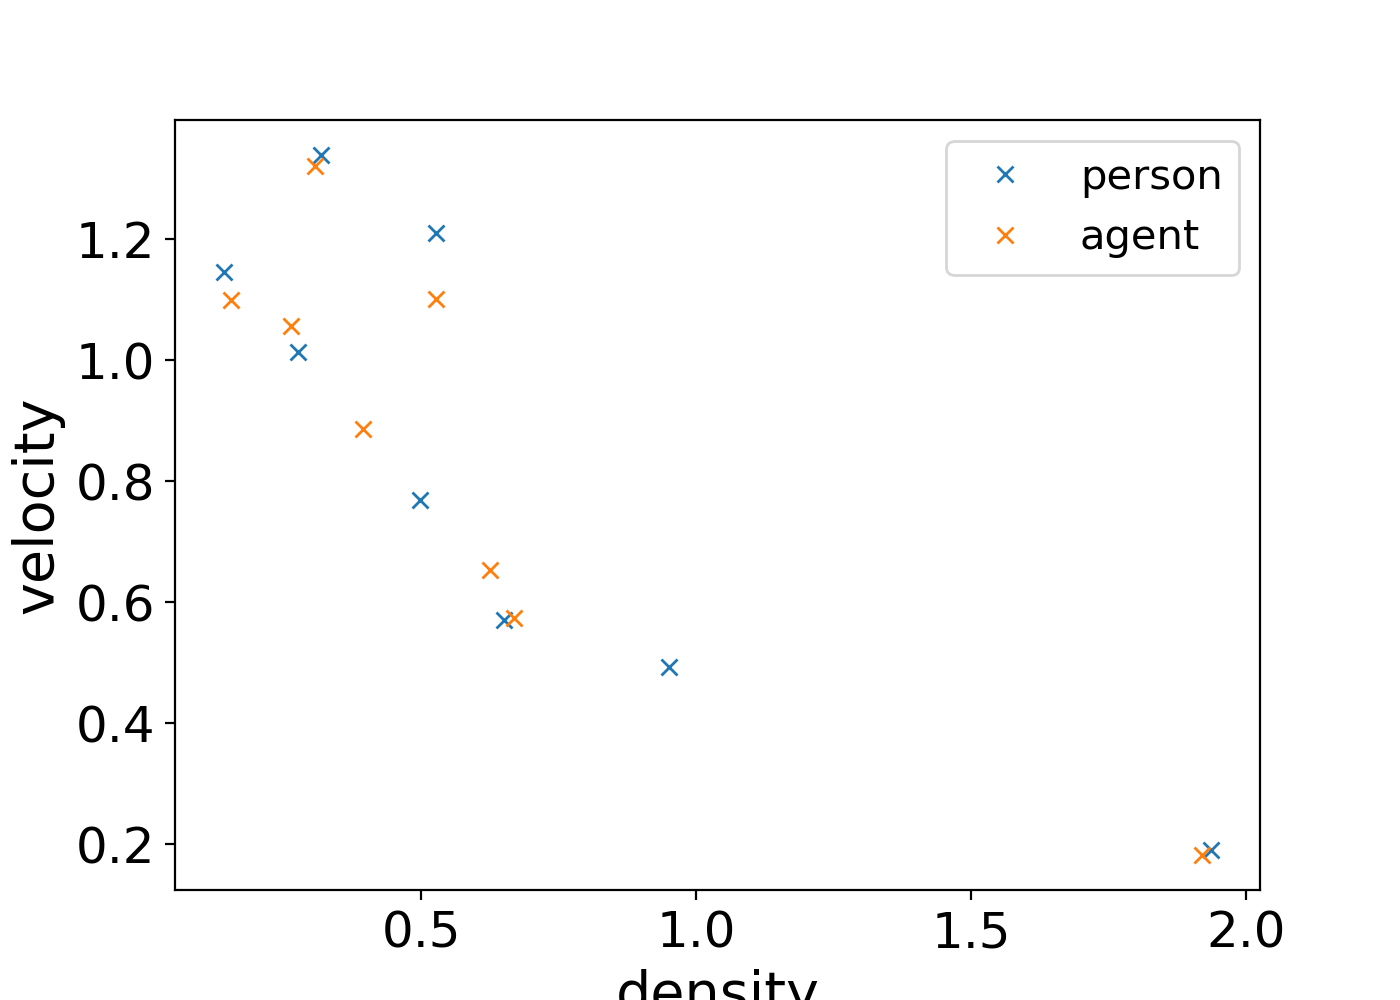

<IPython.core.display.Javascript object>


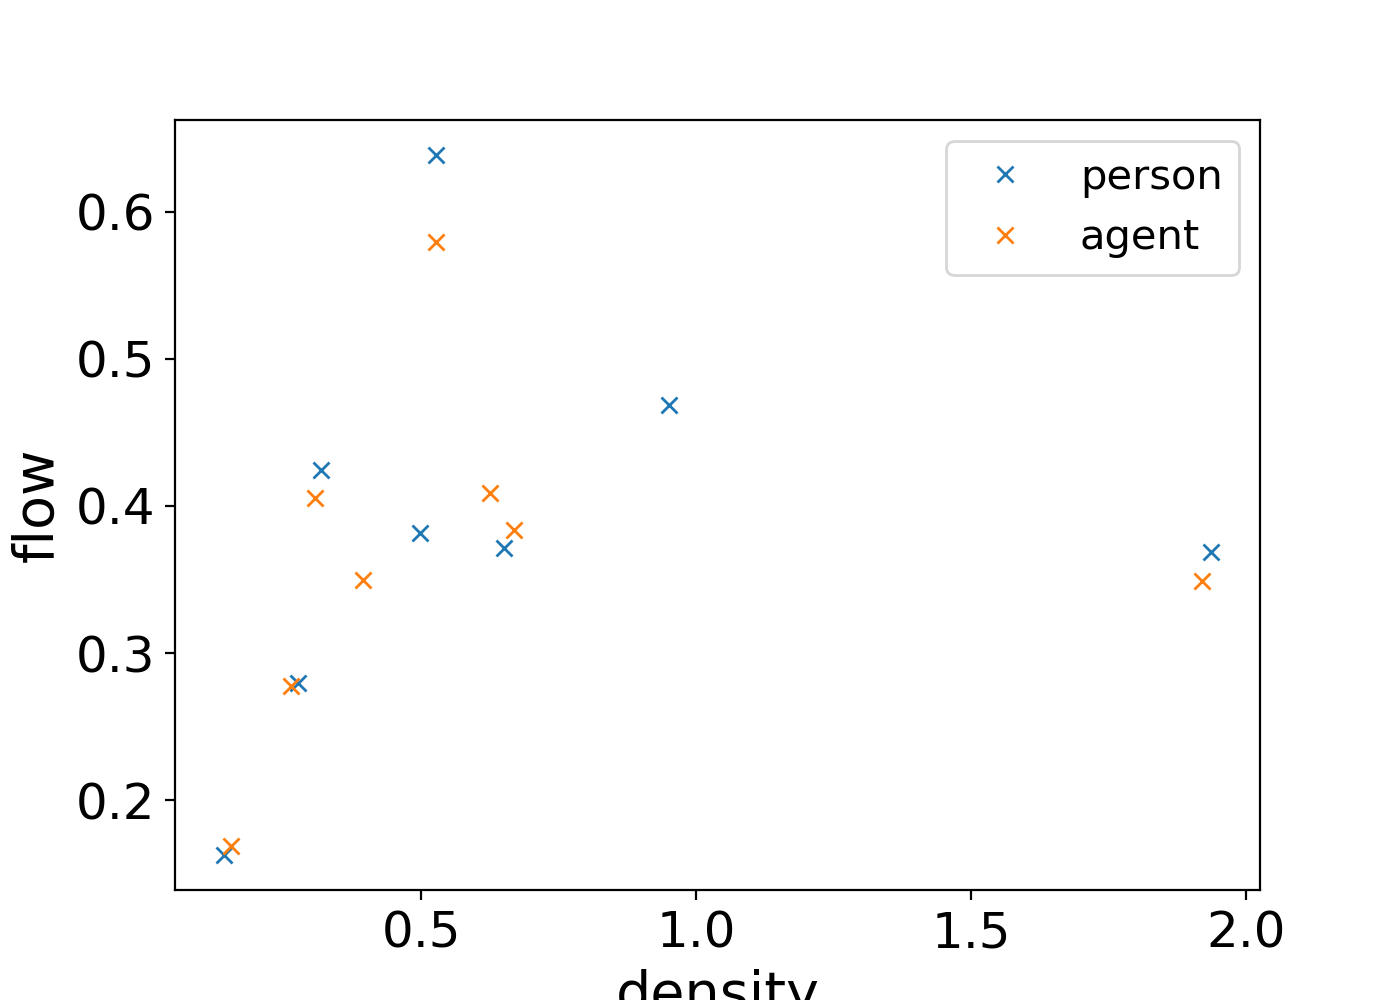

In [269]:
scan = np.load(output)

p_density = scan[:,0]
a_density = scan[:,2]
p_vel = scan[:, 4]
a_vel = scan[:, 6]

plt.figure()
plt.ylabel("velocity")
plt.xlabel("density")
plt.plot(p_density, p_vel, marker="x", ls="", label="person")
plt.plot(a_density, a_vel, marker="x", ls="", label="agent")
plt.legend()
plt.show()

plt.figure()
plt.ylabel("flow")
plt.xlabel("density")
plt.plot(p_density, p_vel*p_density,  marker="x", ls="", label="person")
plt.plot(a_density, a_vel*a_density,  marker="x", ls="", label="agent")
plt.legend()
plt.show()